In [3]:
import networkx as nx
import numpy as np

import itertools
from collections import defaultdict

import random
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
"""
finding adjacency list from graph
"""
def adjList(graph):
    adjList = [[] for _ in range(graph.number_of_nodes())]
    for (src, dest) in graph.edges():
        adjList[src].append(dest)
        adjList[dest].append(src)
    return adjList

"""
finding all hamiltonian paths from a starting vertex, requires adjacency list
"""
def hampath(graph, v, visited, path, c):
    n = graph.number_of_nodes()
    
    if len(path) == n:
        c.extend(path)
#         print(path)
        return
    
    adj_list = adjList(graph)
    
    for w in adj_list[v]:
        if not visited[w]:
            visited[w] = True
            path.append(w)

            hampath(graph, w, visited, path, c)

            visited[w] = False
            path.pop()
"""
finding all hamiltonian paths from starting from all possible vertices, requires adjacency list
"""
def findallHamPaths(graph):
    n = graph.number_of_nodes()
    allpaths = []
    for startV in range(n):
        path = [startV]
        c = []
        visited = [False] * n
        visited[startV] = True
        
        hampath(graph, startV, visited, path, c)
        final = [c[i * n:(i + 1) * n] for i in range((len(c) + n - 1) // n )]
        allpaths.append(final)
        allpathsflat = [item for sublist in allpaths for item in sublist]
    return allpathsflat

### 1. Creating Dummy Database of Songs & Attributes

In [21]:
i_n = 10
i_list = list(range(i_n))

#bpm
# bpm_label = list(["BPM"] * i_n)
i_bpm = [110, 124, 111, 105, 115, 96, 105, 95, 94, 93]

#danceability
# danceability_label = list(["Danceability"] * i_n)
i_dance = [random.random() for i in range(i_n)]

#key
minor_list = ['Ab-','Eb-', 'Bb-', 'F-', 'C-', 'G-', 'D-', 'A-', 'E-', 'B-', 'F#-', 'Db-']
major_list = ['B', 'F#', 'Db', 'Ab', 'Eb', 'Bb', 'F', 'C', 'G', 'D', 'A', 'E']
relation = {}
key_list = minor_list+major_list
i_key = [random.choice(key_list) for i in range(i_n)]


dict1 = list(zip(i_bpm, i_dance, i_key))
# print(dict1)
pd1 = pd.DataFrame(dict1, columns=['BPM', 'Danceability', 'Key'], index = i_list)
pd1.head()


[110, 124, 111, 105, 115, 96, 105, 95, 94, 93]
[0.8845582720198046, 0.9127988883899995, 0.7490566992038302, 0.7902762545980965, 0.006991756429292284, 0.797617196566456, 0.7773625337608941, 0.5079978246260356, 0.018585360342654123, 0.9641753827050281]
['E-', 'E', 'Bb', 'B', 'C', 'D', 'Bb-', 'Bb-', 'Eb-', 'G-']


,BPM,Danceability,Key
0,110,0.884558,E-
1,124,0.912799,E
2,111,0.749057,Bb
3,105,0.790276,B
4,115,0.006992,C


In [14]:
"""
converting dataframe to dict (optional), used to apply attributes for graph
"""
dftest = pd1.to_dict('index')
print(dftest)

{0: {'BPM': [94, 85, 105, 168, 138], 'Danceability': 0.39344914022966315, 'Key': 'C-'}, 1: {'BPM': [94, 85, 105, 168, 138], 'Danceability': 0.39344914022966315, 'Key': 'C-'}, 2: {'BPM': [94, 85, 105, 168, 138], 'Danceability': 0.39344914022966315, 'Key': 'C-'}, 3: {'BPM': [94, 85, 105, 168, 138], 'Danceability': 0.39344914022966315, 'Key': 'C-'}, 4: {'BPM': [94, 85, 105, 168, 138], 'Danceability': 0.39344914022966315, 'Key': 'C-'}}


### 2. Pre-processing data

Taking a look at song attributes, what comparisons/thresholds requirements will we implement to create a sparser graph?

#### Framework for comparing keys 
eg what keys pair well together? based on https://mixedinkey.com/camelot-wheel/

In [23]:

minor_list = ['Ab-','Eb-', 'Bb-', 'F-', 'C-', 'G-', 'D-', 'A-', 'E-', 'B-', 'F#-', 'Db-']
major_list = ['B', 'F#', 'Db', 'Ab', 'Eb', 'Bb', 'F', 'C', 'G', 'D', 'A', 'E']
key_list = minor_list+major_list
xKey = 2
print(key_list[xKey], key_list[xKey-12], key_list[xKey-1], key_list[xKey+1])

def makeKeyDict(keys):
    allKeys = {}
    for i, k in enumerate(keys):
        f0 = keys[i]
        f0p1 = keys[(i+1) % len(keys)]
        f0m1 =  keys[(i-1) % len(keys)]
        f0t = keys[(i+12) % len(keys)]
        if i == 0:
            f0m1 = keys[(i-1) % 12]
        if i == 11:
            f0p1 = keys[(i+1) % 12]
        if i == 12:
            f0m1 = keys[(i-1) % 12+12]
        if i == 23:
            f0p1 = keys[(i+1) % 12+12]
        allKeys[k] = [f0, f0p1, f0m1, f0t]
    return allKeys
# makeKeyDict(key_list)
# key_list[23]

Bb- Db Eb- F-


In [30]:
#---------testing 123, disregard this entire block
pd2test = pd1.copy()
print(pd1)
pd2test.iloc[0]['BPM']-pd2test.iloc[1]['BPM']

djKey =makeKeyDict(key_list)
print(pd2test.iloc[0]['Key'], djKey[pd2test.iloc[1]['Key']])
print(pd2test.iloc[1]['Key'], djKey[pd2test.iloc[0]['Key']])

x = pd2test.iloc[0]['Key'] in djKey[pd2test.iloc[1]['Key']] or  pd2test.iloc[1]['Key'] in djKey[pd2test.iloc[0]['Key']]
print(x)

   BPM  Danceability  Key
0  110      0.884558   E-
1  124      0.912799    E
2  111      0.749057   Bb
3  105      0.790276    B
4  115      0.006992    C
5   96      0.797617    D
6  105      0.777363  Bb-
7   95      0.507998  Bb-
8   94      0.018585  Eb-
9   93      0.964175   G-
E- ['E', 'B', 'A', 'Db-']
E ['E-', 'B-', 'A-', 'G']
False


#### Dataframe -- Generating Edges & Finding Metrics

In [31]:
pdTEST = pd1.copy()
# print(pdTEST)

def createEdges(dfRawData):
    allEdgesdf = pd.DataFrame(
        data=list(itertools.combinations(dfRawData.index.tolist(), 2)), 
        columns=['Src', 'Dst'])
    return allEdgesdf

ex_dfEdges = createEdges(pdTEST)

def calcEdges(dfEdges, dfRawData):
    calc_dfEdges = dfEdges.copy()
    for i, row in dfEdges.iterrows():
        w = 0
        start = row['Src']
        end = row['Dst']
        dBPM = np.abs(dfRawData.iloc[start]['BPM']-dfRawData.iloc[end]['BPM'])
        dDance = np.abs(dfRawData.iloc[start]['Danceability']-dfRawData.iloc[end]['Danceability'])
        dKey = dfRawData.iloc[start]['Key'] in djKey[dfRawData.iloc[end]['Key']] or  dfRawData.iloc[end]['Key'] in djKey[dfRawData.iloc[start]['Key']]
#         print(f"index: {i},{start} -->{end}, dBPM = {dBPM}, dDance = {dDance}, keymatch? = {dKey}")
        calc_dfEdges.at[i,'dBPM'] = dBPM
        calc_dfEdges.at[i,'dDance'] = dDance
        calc_dfEdges.at[i,'keyMatch'] = dKey
        
        if dBPM <= 25:
            w+=1
        if dDance <=0.5:
            w+=1
        if dKey == True:
            w+=1
        calc_dfEdges.at[i,'weight'] = w
        relevantEdges = calc_dfEdges[calc_dfEdges['weight']>0]
    return relevantEdges

calcEdges(ex_dfEdges, pdTEST)



,Src,Dst,dBPM,dDance,keyMatch,weight
0,0,1,14.0,0.028241,False,2.0
1,0,2,1.0,0.135502,False,2.0
2,0,3,5.0,0.094282,False,2.0
3,0,4,5.0,0.877567,False,1.0
4,0,5,14.0,0.086941,False,2.0
5,0,6,5.0,0.107196,False,2.0
6,0,7,15.0,0.376560,False,2.0
7,0,8,16.0,0.865973,False,1.0
8,0,9,17.0,0.079617,False,2.0
9,1,2,13.0,0.163742,False,2.0


### 3. Creating graph from edge dataframe above

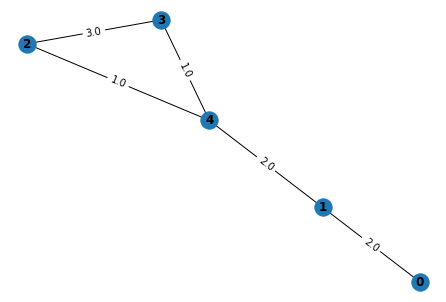

In [21]:
dfGraph = calcEdges(ex_dfEdges, pdTEST)

GG = nx.from_pandas_edgelist(dfGraph, 'Src', 'Dst', ['weight'])

pos = nx.spring_layout(GG)
# nx.draw_networkx(G,pos)
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

nx.draw(GG, pos, with_labels=True, font_weight='bold')
# nx.draw_networkx_labels(GG, pos,labels = dftest)
weight_labels = nx.get_edge_attributes(GG,'weight')
nx.draw_networkx_edge_labels(GG,pos,edge_labels=weight_labels)
plt.show()

### 4. Finding all hamiltonian paths & final "score"
final score is sum of edge weights, the greater the score, the better the path should be

In [80]:
#not important, skip this block
GGallpaths = findallHamPaths(GG)
print(len(GGallpaths))

4


In [83]:
GGallpaths = findallHamPaths(GG)

def getWeight(graph, allpaths):
    for p in allpaths:
#         print(p)
        totalCost = 0
        for i in range(0,len(p)-1):
            edgeCost = graph[p[i]][p[i+1]]['weight']
            totalCost +=edgeCost
#             print(f"----{p[i], p[i+1]}, cost: {graph[p[i]][p[i+1]]['weight']}")         
        print(p, totalCost)
    

#show all paths and final score, higher is better
getWeight(GG, GGallpaths)

[0, 1, 4, 2, 3] 8.0
[0, 1, 4, 3, 2] 8.0
[2, 3, 4, 1, 0] 8.0
[3, 2, 4, 1, 0] 8.0
